In [115]:
import numpy as np
import matplotlib.pyplot as plt
from solvers import *

In [116]:
# Parameters
r = 0.05        # Risk-free rate
sigma = 0.4     # Volatility
K = 1.0         # Strike price
T = 1.0         # Expiry time
lambda_ = 0.005 # Temperature constant
Nx = 100        # Number of space steps
Nt = 100        # Number of time steps

# Space discretization
x_min, x_max = -1, 1  # Domain for x

### Paper Illustration

In [117]:
## The option priced using regularization term R : 

x = np.linspace(x_min, x_max, Nx+1)
U = pde_solver_regularization(r,sigma,K,T,lambda_,Nx,Nt,x_min,x_max)

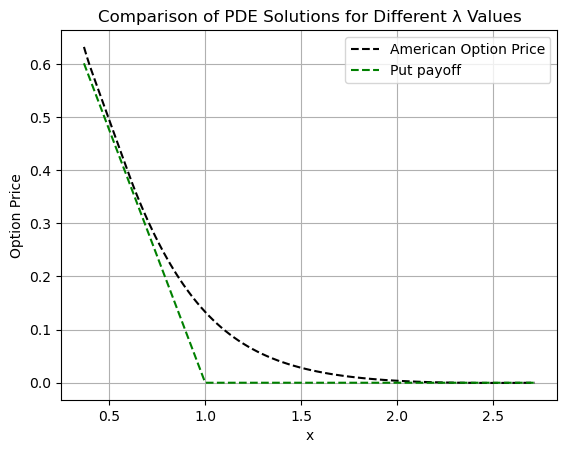

In [118]:
plt.plot(np.exp(x), U, 'k--', label='American Option Price')
plt.plot(np.exp(x),np.exp(-r*T)*np.maximum(K-np.exp(x),0), label = 'Put payoff', linestyle='dashed',color = 'Green')

plt.xlabel('x')
plt.ylabel('Option Price')
plt.title('Comparison of PDE Solutions for Different λ Values')
plt.legend()
plt.grid()
plt.show()

In [119]:
lambda_values = [0.1,0.05,0.01,0.001]
U_values = np.zeros((len(lambda_values),len(x)))

for k,lda in enumerate(lambda_values) : 

    U_values[k] = pde_solver_regularization(r,sigma,K,T,lda,Nx,Nt,x_min,x_max)


U_american_price = penalty_pde_solver(r,sigma,K,T,lambda_,Nx,Nt,x_min,x_max)

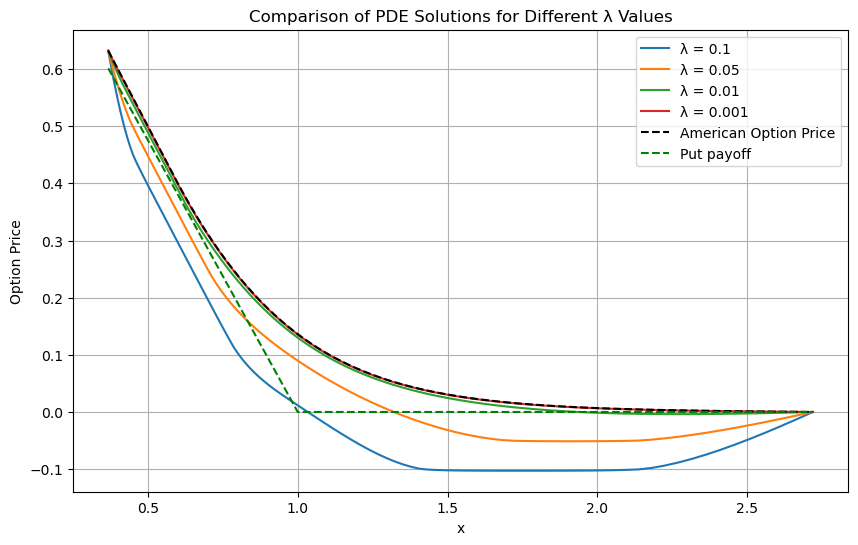

In [120]:
# Plot results
plt.figure(figsize=(10, 6))
for k, lda in enumerate(lambda_values):
    plt.plot(np.exp(x), U_values[k], label=f'λ = {lda}')

# Plot American option price
plt.plot(np.exp(x), U_american_price, 'k--', label='American Option Price')
plt.plot(np.exp(x),np.exp(-r*T)*np.maximum(K-np.exp(x),0), label = 'Put payoff', linestyle='dashed',color = 'Green')

plt.xlabel('x')
plt.ylabel('Option Price')
plt.title('Comparison of PDE Solutions for Different λ Values')
plt.legend()
plt.grid()
plt.show()

### Policy iteration 

### using a simple scipy solver

Start Policy iteration 0


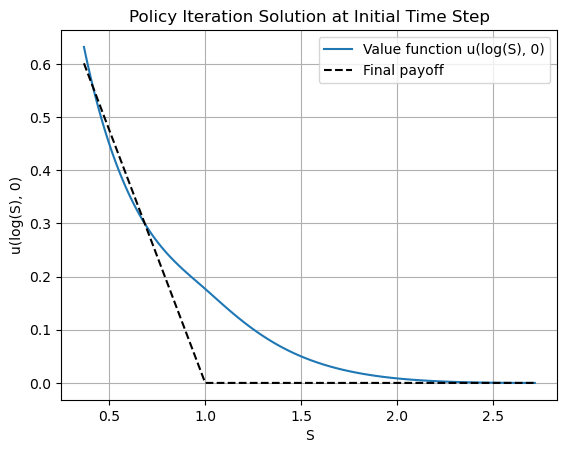

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded
from scipy.optimize import root

# Parameters
r = 0.05        # Risk-free rate
sigma = 0.4     # Volatility
K = 1.0        # Strike price
T = 1.0         # Expiry time
lambda_ = 0.005  # Regularization constant
Nx = 100        # Number of space steps
Nt = 100        # Number of time steps

# Space discretization
x_min, x_max = -1, 1
x = np.linspace(x_min, x_max, Nx+1)
dx = (x_max - x_min) / Nx

# Time discretization
dt = T / Nt
t = np.linspace(0, T, Nt+1)

# Construct L_x matrix coefficients
a = 0.5 * sigma**2 / dx**2 - (r - 0.5 * sigma**2) / (2 * dx)
b = -sigma**2 / dx**2 - r
c = 0.5 * sigma**2 / dx**2 + (r - 0.5 * sigma**2) / (2 * dx)

# Banded matrix for efficient solving
A_banded = np.zeros((3, Nx-1))
A_banded[0, 1:] = c  # Upper diagonal
A_banded[1, :] = 1/dt - b  # Main diagonal (implicit time step)
A_banded[2, :-1] = a  # Lower diagonal

# Initial condition (final condition for backward in time)
h = np.maximum(K - np.exp(x), 1e-6)  # Put option-like function
nu = h.copy()

# Policy iteration parameters
max_policy_iter = 10  # Max number of policy updates
tol = 1e-6  # Convergence tolerance
damping = 0.5  # Damping factor

U = []
# Policy iteration loop
for policy_iter in range(max_policy_iter):

    print(f'Start Policy iteration {policy_iter}')
    pi = np.exp(-(nu - h) / lambda_)  # Policy update step
    
    # Solve PDE for u using Newton's method
    for n in reversed(range(Nt)):
        u_old = nu.copy()
        
        def residual(u_inner):
            u_full = u_old.copy()
            u_full[1:-1] = u_inner  # Fill interior values
            return (u_inner - nu[1:-1]) / dt \
                - (a * u_full[:-2] + b * u_inner + c * u_full[2:]) \
                + (h[1:-1] - u_inner) * pi[1:-1] + lambda_ * (pi[1:-1] - pi[1:-1] * np.log(pi[1:-1]))
        
        sol = root(residual, u_old[1:-1].copy(), method='hybr')  # Solve nonlinear system
        u_old[1:-1] = sol.x  # Update solution
        nu = u_old.copy()

   
    # Check for convergence
    if np.linalg.norm(nu - u_old) < tol:
        break
    
   

# Plot the final function
plt.plot(np.exp(x), nu, label='Value function u(log(S), 0)')
plt.plot(np.exp(x), np.exp(-r*T) * np.maximum(K - np.exp(x), 0), label='Final payoff', linestyle='dashed', color='black')
plt.xlabel("S")
plt.ylabel("u(log(S), 0)")
plt.title("Policy Iteration Solution at Initial Time Step")
plt.legend()
plt.grid()
plt.show()

### Sparse solver

In [212]:

# Parameters
r = 0.05        # Risk-free rate
sigma = 0.4     # Volatility
K = 1.0        # Strike price
T = 1.0         # Expiry time
lambda_ = 0.005  # Regularization constant
Nx = 100        # Number of space steps
Nt = 100        # Number of time steps

# Space discretization
x_min, x_max = -1, 1
x = np.linspace(x_min, x_max, Nx+1)
dx = (x_max - x_min) / Nx

# Time discretization
dt = T / Nt
t = np.linspace(0, T, Nt+1)

# Construct L_x matrix coefficients
a = 0.5 * sigma**2 / dx**2 - (r - 0.5 * sigma**2) / (2 * dx)
b = -sigma**2 / dx**2 - r
c = 0.5 * sigma**2 / dx**2 + (r - 0.5 * sigma**2) / (2 * dx)

# Banded matrix for efficient solving
A_banded = np.zeros((3, Nx-1))
A_banded[0, 1:] = c  # Upper diagonal
A_banded[1, :] = 1/dt - b  # Main diagonal (implicit time step)
A_banded[2, :-1] = a  # Lower diagonal

# Initial condition (final condition for backward in time)
h = np.maximum(K - np.exp(x), 1e-6)  # Put option-like function
nu = h.copy()

Policy Iteration 1
Policy Iteration 2
Policy Iteration 3
Policy Iteration 4
Policy Iteration 5
Policy Iteration 6
Policy Iteration 7
Policy Iteration 8
Policy Iteration 9
Policy Iteration 10
Policy Iteration 11
Policy Iteration 12
Policy Iteration 13
Policy Iteration 14
Policy Iteration 15
Policy Iteration 16
Policy Iteration 17
Policy Iteration 18
Policy Iteration 19
Policy Iteration 20


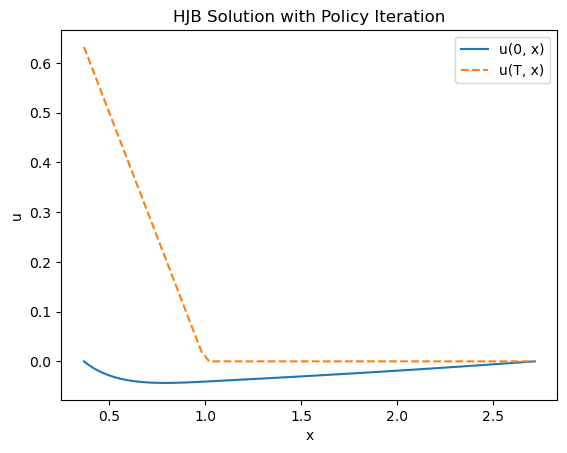

In [255]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Parameters
T = 1.0   # Final time
Nt = 100  # Number of time steps
Nx = 50   # Number of spatial points
sigma = 0.2
r = 0.05
lambda_ = 0.001  # Regularization parameter
xmin, xmax = -1, 1  # Space domain
dx = (xmax - xmin) / (Nx - 1)
dt = T / Nt

# Space grid
x = np.linspace(xmin, xmax, Nx)

# Final condition u(T, x) = max(0, 1 - exp(x))
u = np.zeros((Nt, Nx))
u[-1, :] = np.maximum(0, 1 - np.exp(x))  # Apply final condition

# Initialize policy π (start with uniform policy)
pi = np.ones(Nx)

# Finite difference coefficients
alpha = 0.5 * sigma**2 / dx**2
beta = (r - 0.5 * sigma**2) / (2 * dx)
gamma = r

# Policy iteration loop
max_iter = 20
tol = 1e-6

for iteration in range(max_iter):
    print(f"Policy Iteration {iteration+1}")

    # Construct the tridiagonal matrix for implicit scheme
    diagonal = (1 + 2 * alpha + gamma * dt) * np.ones(Nx - 2)
    lower = (-alpha - beta) * np.ones(Nx - 3)
    upper = (-alpha + beta) * np.ones(Nx - 3)
    J = diags([lower, diagonal, upper], offsets=[-1, 0, 1]).tocsc()

    # Time-stepping (backward)
    for n in range(Nt - 1, 0, -1):
        H = (1 - np.exp(x[1:-1]) - u[n, 1:-1]) * pi[1:-1] + lambda_ * (pi[1:-1] * np.log(pi[1:-1]) - pi[1:-1])
        rhs = u[n, 1:-1] - dt * H
        u_next = spsolve(J, rhs)
        u[n-1, 1:-1] = u_next  # Update solution

    # Policy improvement step
    new_pi = np.exp((-u[0, :] + np.maximum(1 - np.exp(x), 0)) / lambda_)
    new_pi = np.clip(new_pi, 1e-6, 1)  # Avoid numerical issues

    # Convergence check
    if np.max(np.abs(new_pi - pi)) < tol:
        print("Policy Converged!")
        break
    pi = new_pi.copy()

# Plot u(0, x) and u(T, x)
plt.plot(np.exp(x), u[0, :], label="u(0, x)")
plt.plot(np.exp(x), u[-1, :], label="u(T, x)", linestyle="dashed")
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.title("HJB Solution with Policy Iteration")
plt.show()

In [331]:
def Lx_operator(Nx, dx, sigma, r):
    alpha = (sigma**2) / (2 * dx**2)
    beta = (r - 0.5 * sigma**2) / (2 * dx)

    diagonal = (-2 * alpha-r) * np.ones(Nx)
    lower = (alpha - beta) * np.ones(Nx - 1)
    upper = (alpha + beta) * np.ones(Nx - 1)

    Lx = diags([lower, diagonal, upper], offsets=[-1, 0, 1], shape=(Nx, Nx)).tocsc()
    return Lx

Policy Iteration 1
Policy Iteration 2
Policy Iteration 3
Policy Iteration 4
Policy Iteration 5
Policy Iteration 6
Policy Iteration 7
Policy Iteration 8
Policy Iteration 9
Policy Iteration 10
Policy Iteration 11
Policy Iteration 12
Policy Iteration 13
Policy Iteration 14
Policy Iteration 15
Policy Iteration 16
Policy Iteration 17
Policy Iteration 18
Policy Iteration 19
Policy Iteration 20


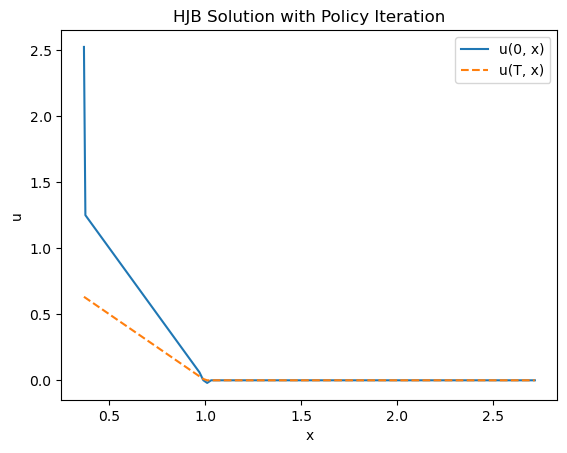

In [332]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Parameters
T = 1.0   
Nt = 100  
Nx = 100  
sigma = 0.4
r = 0.05
lambda_ = 0.001  
xmin, xmax = -1, 1  
dx = (xmax - xmin) / (Nx - 1)
dt = T / Nt
K= 1
# Space grid
x = np.linspace(xmin, xmax, Nx)

# Final condition u(T, x) = max(0, 1 - exp(x))
# Initialize policy π (start with uniform policy)

# Finite difference coefficients
alpha = 0.5 * sigma**2 / dx**2
beta = (r - 0.5 * sigma**2) / (2 * dx)
gamma = r

# Policy iteration loop
max_iter = 20
tol = 1e-6

Lx = Lx_operator(Nx, dx, sigma, r)


for iteration in range(max_iter):
    print(f"Policy Iteration {iteration+1}")
    h = np.maximum(K - np.exp(x), 0)  # Put option-like function
    nu = h.copy()
    pi = np.ones_like(x)
    
    # Time-stepping (backward)
    for n in reversed(range(Nt)):
        u_old = nu.copy()
        H = (np.maximum(1 - np.exp(x), 0) - u_old) * pi + lambda_ * (-pi * np.log(pi) + pi)

        update =u_old-(Lx@u_old +H)*dt
        u_old +=update
    # Policy improvement step
    new_pi = np.exp((-u_old + np.maximum(1 - np.exp(x), 0)) / lambda_)
    #new_pi = np.clip(new_pi, 1e-6, 1)  

    # Convergence check
    if np.max(np.abs(nu - u_old)) < tol:
        print("Policy Converged!")
        break

    # Update policy
    pi = new_pi
    nu = u_old.copy()

# Plot u(0, x) and u(T, x)
plt.plot(np.exp(x), nu, label="u(0, x)")
plt.plot(np.exp(x), np.maximum(0, 1 - np.exp(x))  , label="u(T, x)", linestyle="dashed")
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.title("HJB Solution with Policy Iteration")
plt.show()

In [368]:
v = (J_F(0)@x)

In [377]:
np.eye(Nx)-dt*Lx.toarray()-dt*np.diag(pi)

array([[ 4.9104  , -1.952775,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [-1.967625,  4.9104  , -1.952775, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      , -1.967625,  4.9104  , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  4.9104  , -1.952775,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ..., -1.967625,  4.9104  ,
        -1.952775],
       [ 0.      ,  0.      ,  0.      , ...,  0.      , -1.967625,
         4.9104  ]])

In [385]:
J_F = lambda x : np.eye(Nx)-dt*Lx.toarray() -dt*np.diag(pi)
F = lambda x :  (J_F(0)@x -u_old+  (h - u_old) * pi + lambda_ * (-pi * np.log(pi) + pi) )


# Solve J_F Δu = -F
solution = root(F, nu, jac=J_F, method='hybr')
u_old  = solution.x

C:\Users\moham\AppData\Local\Temp\ipykernel_21120\1588478085.py:2: RuntimeWarning: divide by zero encountered in log
  F = lambda x :  (J_F(0)@x -u_old+  (h - u_old) * pi + lambda_ * (-pi * np.log(pi) + pi) )
C:\Users\moham\AppData\Local\Temp\ipykernel_21120\1588478085.py:2: RuntimeWarning: invalid value encountered in multiply
  F = lambda x :  (J_F(0)@x -u_old+  (h - u_old) * pi + lambda_ * (-pi * np.log(pi) + pi) )
C:\Users\moham\AppData\Local\Temp\ipykernel_21120\1588478085.py:2: RuntimeWarning: invalid value encountered in add
  F = lambda x :  (J_F(0)@x -u_old+  (h - u_old) * pi + lambda_ * (-pi * np.log(pi) + pi) )


In [390]:
h = np.maximum(K - np.exp(x), 0)  # Put option-like function
nu = h.copy()
pi = np.ones_like(x)
damping = 0.5 

solution = root(F, nu, jac=J_F, method='hybr')
u_old  = solution.x

Policy Iteration 1
Policy Iteration 2
Policy Iteration 3
Policy Iteration 4
Policy Iteration 5


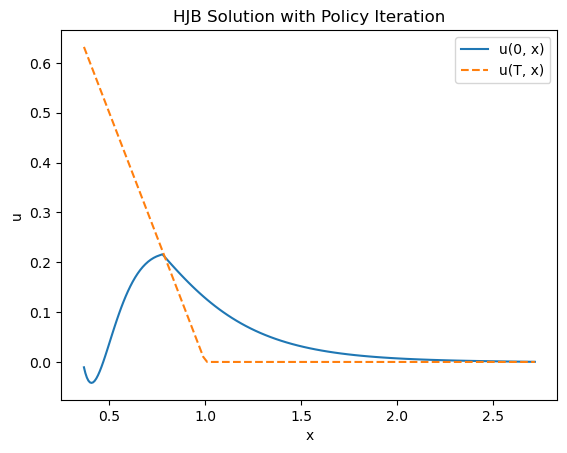

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Parameters
T = 1.0   
Nt = 100  
Nx = 100  
sigma = 0.4
r = 0.05
lambda_ = 0.001  
xmin, xmax = -1, 1  
dx = (xmax - xmin) / (Nx - 1)
dt = T / Nt
K = 1

# Space grid
x = np.linspace(xmin, xmax, Nx)

# Finite difference coefficients
alpha = 0.5 * sigma**2 / dx**2
beta = (r - 0.5 * sigma**2) / (2 * dx)
gamma = r

# Construct Lx operator
def Lx_operator(Nx, dx, sigma, r):
    alpha = 0.5 * sigma**2 / dx**2
    beta = (r - 0.5 * sigma**2) / (2 * dx)
    
    diagonal = (-2 * alpha+r )* np.ones(Nx)
    lower = (alpha - beta) * np.ones(Nx - 1)
    upper = (alpha + beta) * np.ones(Nx - 1)
    
    Lx = diags([lower, diagonal, upper], offsets=[-1, 0, 1]).tocsc()
    return Lx

Lx = Lx_operator(Nx, dx, sigma, r)

# Policy iteration loop
max_iter = 5
tol = 1e-6

pi = np.exp((-h + np.maximum(1 - np.exp(x), 0)) / lambda_)

for iteration in range(max_iter):
    print(f"Policy Iteration {iteration+1}")
    
    # Initialize the value function with the terminal condition
    h = np.maximum(K - np.exp(x), 0)  # Put option-like function
    nu = h.copy()

    # Time-stepping (backward)
    for n in reversed(range(Nt)):
        u_old = nu.copy()
        
        # Newton's method to solve F(u^n) = 0
        J = (np.eye(Nx)-dt*Lx.toarray())
        Jac =  np.eye(Nx)-dt*Lx.toarray() -dt*np.diag(pi)
        rho = u_old-dt*h*pi -dt*lambda_ * (-pi * np.log(pi) + pi)
        u_old  = spsolve(Jac, rho)

        nu = u_old.copy()
    
    # Policy improvement step
    new_pi = np.exp((-nu + np.maximum(1 - np.exp(x), 0)) / lambda_)
    #new_pi = np.clip(new_pi, 1e-6, 1) 

    # Convergence check
    if np.max(np.abs(new_pi - pi)) < tol:
        print("Policy Converged!")
        break

    # Update policy
    pi = new_pi.copy()

# Plot u(0, x) and u(T, x)
plt.plot(np.exp(x), nu, label="u(0, x)")
plt.plot(np.exp(x), np.maximum(0, 1 - np.exp(x)), label="u(T, x)", linestyle="dashed")
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.title("HJB Solution with Policy Iteration")
plt.show()


In [415]:
Lx.toarray()[:3,:3]

array([[-391.99  ,  195.2775,    0.    ],
       [ 196.7625, -391.99  ,  195.2775],
       [   0.    ,  196.7625, -391.99  ]])

Policy Iteration 1
Policy Iteration 2
Policy Iteration 3
Policy Iteration 4
Policy Iteration 5


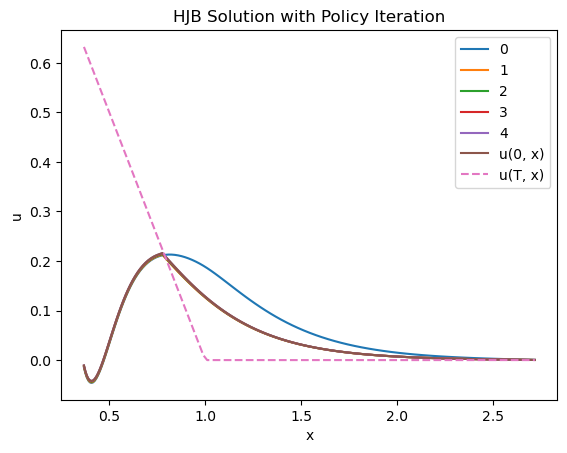

In [422]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Parameters
T = 1.0   
Nt = 100  
Nx = 100  
sigma = 0.4
r = 0.05
lambda_ = 0.001  
xmin, xmax = -1, 1  
dx = (xmax - xmin) / (Nx - 1)
dt = T / Nt
K = 1

# Space grid
x = np.linspace(xmin, xmax, Nx)

# Construct Lx operator
def Lx_operator(Nx, dx, sigma, r):
    alpha = 0.5 * sigma**2 / dx**2
    beta = (r - 0.5 * sigma**2) / (2 * dx)
    
    diagonal = (-2 * alpha + r) * np.ones(Nx)
    lower = (alpha - beta) * np.ones(Nx - 1)
    upper = (alpha + beta) * np.ones(Nx - 1)
    
    return diags([lower, diagonal, upper], offsets=[-1, 0, 1]).tocsc()

Lx = Lx_operator(Nx, dx, sigma, r)

# Policy iteration loop
max_iter = 5
tol = 1e-6

# Initialize h (payoff function)
h = np.maximum(K - np.exp(x), 0)  # Put option-like function
pi = np.exp((-h + np.maximum(1 - np.exp(x), 0)) / lambda_)  # Corrected: Defined after h

for iteration in range(max_iter):
    print(f"Policy Iteration {iteration+1}")

    # Initialize the value function with the terminal condition
    nu = h.copy()

    # Time-stepping (backward)
    for n in reversed(range(Nt)):
        u_old = nu.copy()

        # Compute H(u) term
        H = (np.maximum(1 - np.exp(x), 0)) * pi + lambda_ * (-pi * np.log(pi) + pi)

        # Define Jacobian and solve using Newton's method
        Jac = (diags([1], [0], shape=(Nx, Nx)).tocsc() - dt * Lx - dt * diags(pi, 0))
        rhs = u_old - dt * H
        u_old = spsolve(Jac, rhs)  # Solve the linear system

        nu = u_old.copy()

    plt.plot(np.exp(x), nu,label = iteration)

    # Policy improvement step
    new_pi = np.exp((-nu + np.maximum(1 - np.exp(x), 0)) / lambda_)

    # Convergence check
    if np.max(np.abs(new_pi - pi)) < tol:
        print("Policy Converged!")
        break

    # Update policy
    pi = new_pi.copy()

# Plot u(0, x) and u(T, x)
plt.plot(np.exp(x), nu, label="u(0, x)")
plt.plot(np.exp(x), np.maximum(0, 1 - np.exp(x)), label="u(T, x)", linestyle="dashed")
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.title("HJB Solution with Policy Iteration")
plt.show()


Policy Iteration 1
Policy Iteration 2
Policy Iteration 3


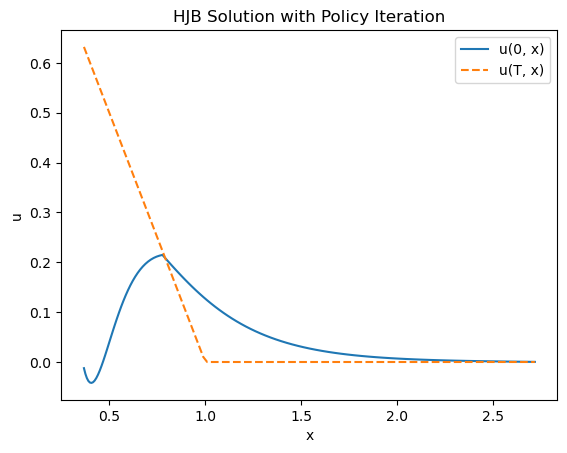

In [452]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Parameters
T = 1.0   
Nt = 100  
Nx = 100  
sigma = 0.4
r = 0.05
lambda_ = 0.001  
xmin, xmax = -1, 1  
dx = (xmax - xmin) / (Nx - 1)
dt = T / Nt
K = 1

# Space grid
x = np.linspace(xmin, xmax, Nx)

# Finite difference coefficients
alpha = 0.5 * sigma**2 / dx**2
beta = (r - 0.5 * sigma**2) / (2 * dx)

# Construct Lx operator
def Lx_operator(Nx, dx, sigma, r):
    alpha = 0.5 * sigma**2 / dx**2
    beta = (r - 0.5 * sigma**2) / (2 * dx)
    
    diagonal = (-2 * alpha + r) * np.ones(Nx)
    lower = (alpha - beta) * np.ones(Nx - 1)
    upper = (alpha + beta) * np.ones(Nx - 1)
    
    Lx = diags([lower, diagonal, upper], offsets=[-1, 0, 1]).tocsc()
    return Lx

Lx = Lx_operator(Nx, dx, sigma, r)

# Terminal condition h(x)
h = np.maximum(K - np.exp(x), 0)  # Put option-like function

# Policy iteration loop
max_iter = 3
tol = 1e-6


# Initialize policy π using equation (3.6)
pi = np.ones_like(x)

for iteration in range(max_iter):
    print(f"Policy Iteration {iteration+1}")
    
    # Initialize the value function with the terminal condition
    nu = h.copy()
   
    # Time-stepping (backward Euler)
    for n in range(Nt-1,0,-1):
        u_old = nu.copy()
        
        # Compute Hamiltonian term H(x, π, u)
        H = (h) * pi + lambda_ * (pi - pi * np.log(pi))

        # Solve the system (I - dt * Lx - dt * diag(pi)) u = u_old - dt * H
        J = (np.eye(Nx) - dt * Lx.toarray() - dt * np.diag(pi))
        rhs = u_old - dt * H
        u_new = spsolve(J, rhs)

        nu = u_new.copy()
    
    # Policy improvement step using equation (3.6)
    new_pi = np.exp((-nu + h) / lambda_)
    
    # Convergence check
    if np.max(np.abs(new_pi - pi)) < tol:
        print("Policy Converged!")
        break

    # Update policy
    pi = new_pi.copy()

# Plot u(0, x) and terminal condition u(T, x)
plt.plot(np.exp(x), nu, label="u(0, x)")
plt.plot(np.exp(x), h, label="u(T, x)", linestyle="dashed")
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.title("HJB Solution with Policy Iteration")
plt.show()

Policy Iteration 1
Policy Iteration 2
Policy Iteration 3
Policy Iteration 4
Policy Iteration 5
Policy Iteration 6
Policy Iteration 7
Policy Iteration 8
Policy Iteration 9
Policy Iteration 10
Policy Iteration 11
Policy Iteration 12
Policy Iteration 13
Policy Iteration 14
Policy Iteration 15
Policy Iteration 16
Policy Iteration 17
Policy Iteration 18
Policy Iteration 19
Policy Iteration 20
Policy Iteration 21
Policy Iteration 22
Policy Iteration 23
Policy Iteration 24
Policy Iteration 25
Policy Iteration 26
Policy Iteration 27
Policy Iteration 28
Policy Iteration 29
Policy Iteration 30
Policy Iteration 31
Policy Iteration 32
Policy Iteration 33
Policy Iteration 34
Policy Iteration 35
Policy Iteration 36
Policy Iteration 37
Policy Iteration 38
Policy Iteration 39
Policy Iteration 40
Policy Iteration 41
Policy Iteration 42
Policy Iteration 43
Policy Iteration 44
Policy Iteration 45
Policy Iteration 46
Policy Iteration 47
Policy Iteration 48
Policy Iteration 49
Policy Iteration 50
Policy It

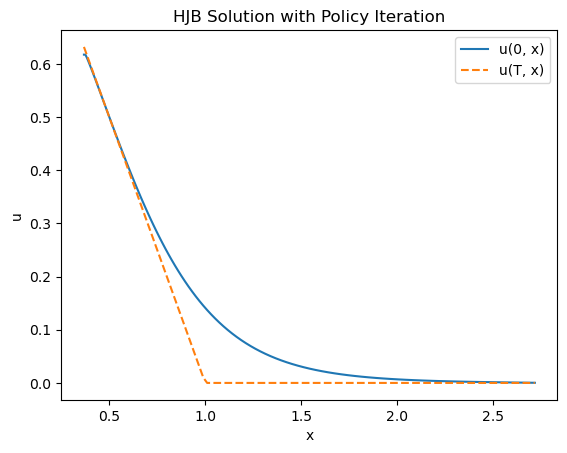

In [531]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Parameters
T = 1.0   
Nt = 100  
Nx = 100  
sigma = 0.4
r = 0.05
lambda_ = 0.001  
xmin, xmax = -1, 1  
dx = (xmax - xmin) / (Nx - 1)
dt = T / Nt
K = 1

# Space grid
x = np.linspace(xmin, xmax, Nx)

# Finite difference coefficients
alpha = 0.5 * sigma**2 / dx**2
beta = (r - 0.5 * sigma**2) / (2 * dx)

# Construct Lx operator
def Lx_operator(Nx, dx, sigma, r):
    alpha = 0.5 * sigma**2 / dx**2
    beta = (r - 0.5 * sigma**2) / (2 * dx)
    
    diagonal = (-2 * alpha + r) * np.ones(Nx)
    lower = (alpha - beta) * np.ones(Nx - 1)
    upper = (alpha + beta) * np.ones(Nx - 1)
    
    Lx = diags([lower, diagonal, upper], offsets=[-1, 0, 1]).tocsc()
    return Lx

Lx = Lx_operator(Nx, dx, sigma, r)

# Terminal condition h(x)
h = np.maximum(K - np.exp(x), 0)  # Put option-like function

# Policy iteration loop
max_iter = 100
tol = 1e-6

# Initialize policy π using equation (3.6)
U = np.zeros((Nt,Nx))
U[-1,:] = h
pi = np.ones_like(U)

for iteration in range(max_iter):
    print(f"Policy Iteration {iteration+1}")
    
    # Initialize the value function with the terminal condition
    U_new = np.zeros_like(U)
    U_new[-1,:] = h

    # Time-stepping (backward Euler)
    for n in range(Nt-1,0,-1):

        # Compute Hamiltonian term H(x, π, u)
        H = (h) * pi[n-1,:] + lambda_ * (pi[n-1,:] - pi[n-1,:] * np.log(pi[n-1,:]))

        # Solve the system (I - dt * Lx - dt * diag(pi)) u = u_old - dt * H
        J = (np.eye(Nx) - dt * Lx.toarray() + dt * np.diag(pi[n-1,:]))
        rhs = U[n,:] + dt * H
        U_new[n-1,:] = spsolve(J, rhs)
    # Policy improvement step using equation (3.6)
    
    #new_pi = np.exp((-U_new + h) / lambda_).copy()
    new_pi = np.exp(np.clip((-U_new + h) / lambda_, -10, 10)) # Clipping for stability
    
    # Convergence check
    if np.max(np.abs(new_pi - pi)) < tol:
        print("Policy Converged!")
        break

    # Update policy
    pi = new_pi.copy()
    U = U_new.copy()
# Plot u(0, x) and terminal condition u(T, x)
plt.plot(np.exp(x), U_new[0,:], label="u(0, x)")
plt.plot(np.exp(x), h, label="u(T, x)", linestyle="dashed")
plt.legend()
plt.xlabel("x")
plt.ylabel("u")
plt.title("HJB Solution with Policy Iteration")
plt.show()

In [30]:
def policy_iteration_solver(r,sigma,K,T,lambda_,Nx,Nt,xmin,xmax,max_iter,tol) : 


        u_list = []
        dx = (xmax - xmin) / (Nx - 1)
        dt = T / Nt
        K = 1

        # Space grid
        x = np.linspace(xmin, xmax, Nx)


        # Time discretization
        dt = T / Nt  

        # Construct Lx operator
        def Lx_operator(Nx, dx, sigma, r):
                alpha = 0.5 * sigma**2 / dx**2
                beta = (r - 0.5 * sigma**2) / (2 * dx)
                
                diagonal = (-2 * alpha + r) * np.ones(Nx)
                lower = (alpha - beta) * np.ones(Nx - 1)
                upper = (alpha + beta) * np.ones(Nx - 1)
                
                Lx = diags([lower, diagonal, upper], offsets=[-1, 0, 1]).tocsc()
                return Lx

        Lx = Lx_operator(Nx, dx, sigma, r)

        # Terminal condition h(x)
        h = np.maximum(K - np.exp(x), 0)  # Put option-like function
        # Initialize policy π using equation (3.6)
        U = np.zeros((Nt,Nx))
        U[-1,:] = h
        pi = np.ones_like(U)

        for iteration in range(max_iter):

                print(f"Policy Iteration {iteration+1}")
        
                # Initialize the value function with the terminal condition
                U_new = np.zeros_like(U)
                U_new[-1,:] = h

                # Time-stepping (backward Euler)
                for n in range(Nt-1,0,-1):

                        # Compute Hamiltonian term H(x, π, u)
                        H = (h) * pi[n-1,:] + lambda_ * (pi[n-1,:] - pi[n-1,:] * np.log(pi[n-1,:]))

                        # Solve the system (I - dt * Lx - dt * diag(pi)) u = u_old - dt * H
                        J = (np.eye(Nx) - dt * Lx.toarray() + dt * np.diag(pi[n-1,:]))
                        rhs = U[n,:] + dt * H
                        U_new[n-1,:] = spsolve(J, rhs)
                # Policy improvement step using equation (3.6)
                
                #new_pi = np.exp((-U_new + h) / lambda_).copy()
                new_pi = np.exp(np.clip((-U_new + h) / lambda_, -10, 10)) # Clipping for stability
        
                # Convergence check
                if np.max(np.abs(new_pi - pi)) < tol:
                        print("Policy Converged!")
                        break

                # Update policy
                pi = new_pi.copy()
                U = U_new.copy()

                u_list.append(U[0,:])
        
        return x,u_list


        
    

### Test the convergence : 

In [39]:
import solvers
import importlib 

importlib.reload(solvers)

<module 'solvers' from 'c:\\Users\\Ben\\RL\\solvers.py'>

In [36]:
# Parameters


T = 1.0   
Nt = 100  
Nx = 100  
sigma = 0.4
r = 0.05
lambda_ = 0.001  
xmin, xmax = -1, 1  
max_iter = 100
x,U = policy_iteration_solver(r,sigma,K,T,lambda_,Nx,Nt,xmin,xmax,max_iter,tol)

Policy Iteration 1
Policy Iteration 2
Policy Iteration 3
Policy Iteration 4
Policy Iteration 5


C:\Users\moham\AppData\Roaming\Python\Python38\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


Policy Iteration 6
Policy Iteration 7
Policy Iteration 8
Policy Iteration 9
Policy Iteration 10
Policy Iteration 11
Policy Iteration 12
Policy Iteration 13
Policy Iteration 14
Policy Iteration 15
Policy Iteration 16
Policy Iteration 17
Policy Iteration 18
Policy Iteration 19
Policy Iteration 20
Policy Iteration 21
Policy Iteration 22
Policy Iteration 23
Policy Iteration 24
Policy Iteration 25
Policy Iteration 26
Policy Iteration 27
Policy Iteration 28
Policy Iteration 29
Policy Iteration 30
Policy Iteration 31
Policy Iteration 32
Policy Iteration 33
Policy Iteration 34
Policy Iteration 35
Policy Iteration 36
Policy Iteration 37
Policy Iteration 38
Policy Iteration 39
Policy Iteration 40
Policy Iteration 41
Policy Iteration 42
Policy Iteration 43
Policy Iteration 44
Policy Iteration 45
Policy Iteration 46
Policy Iteration 47
Policy Iteration 48
Policy Iteration 49
Policy Iteration 50
Policy Iteration 51
Policy Iteration 52
Policy Iteration 53
Policy Iteration 54
Policy Iteration 55
Poli

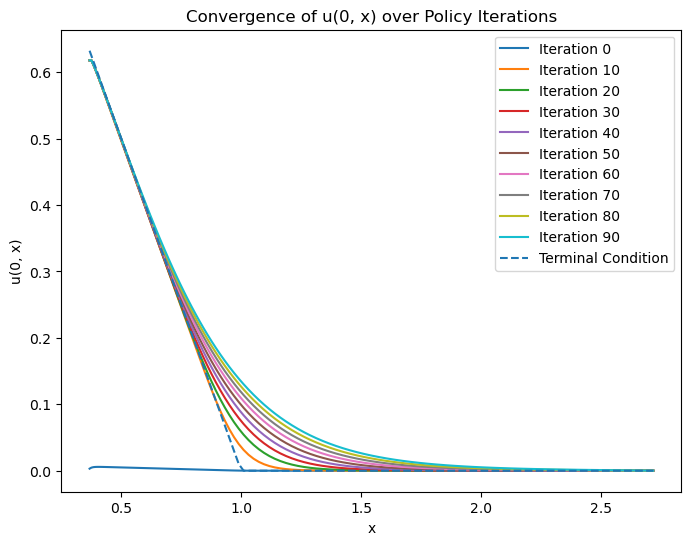

In [37]:
x_vals, u_0_iterations =x,U 

# Plot results for different iterations
plt.figure(figsize=(8, 6))
for i, u_0 in enumerate(u_0_iterations):

    if i % 10 ==0 :
        plt.plot(np.exp(x_vals), u_0, label=f"Iteration {i}")

plt.plot(np.exp(x_vals), np.maximum(1 - np.exp(x_vals), 0), linestyle="dashed", label="Terminal Condition")
plt.legend()
plt.xlabel("x")
plt.ylabel("u(0, x)")
plt.title("Convergence of u(0, x) over Policy Iterations")
plt.show()
